In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import itertools as it
from IPython.display import display
import pickle, os
%config InlineBackend.figure_format = 'retina'

In [3]:
def box3d(n=16): 
    points = [] 
    N = tuple(np.linspace(-1, 1, n)) 
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]: 
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
    return np.hstack(points)/2

def Pi(p:np.ndarray | list) -> np.ndarray:
    """convert from homogeneous coordinates to inhomogeneous coordinates

    subtract one coordinate"""
    if isinstance(p, np.ndarray):
        return p[:-1]/p[-1]
    elif isinstance(p, list):
        return [Pi(np.array(p_)) for p_ in p]

def PiInv(p:np.ndarray | list) -> np.ndarray:
    """convert from inhomogeneous coordinates to homogeneous coordinates

    add one coordinate with value 1"""
    if isinstance(p, np.ndarray):
        return np.vstack((p, np.ones(p.shape[1])))
    elif isinstance(p, list):
        return [PiInv(np.array(p_)) for p_ in p]

def projectpoints(K, R, t, Q):
    """project 3D points to 2D"""
    Rt = np.concatenate((R, t), axis=1)
    return Pi(K @ Rt @ PiInv(Q))

2.1
$f=600, \alpha=1,\beta=0,\delta x = \delta y = 400$

derfor er kameraets opløsning = 800x800 pixels, da man flytter midten 400 px for at komme til midten

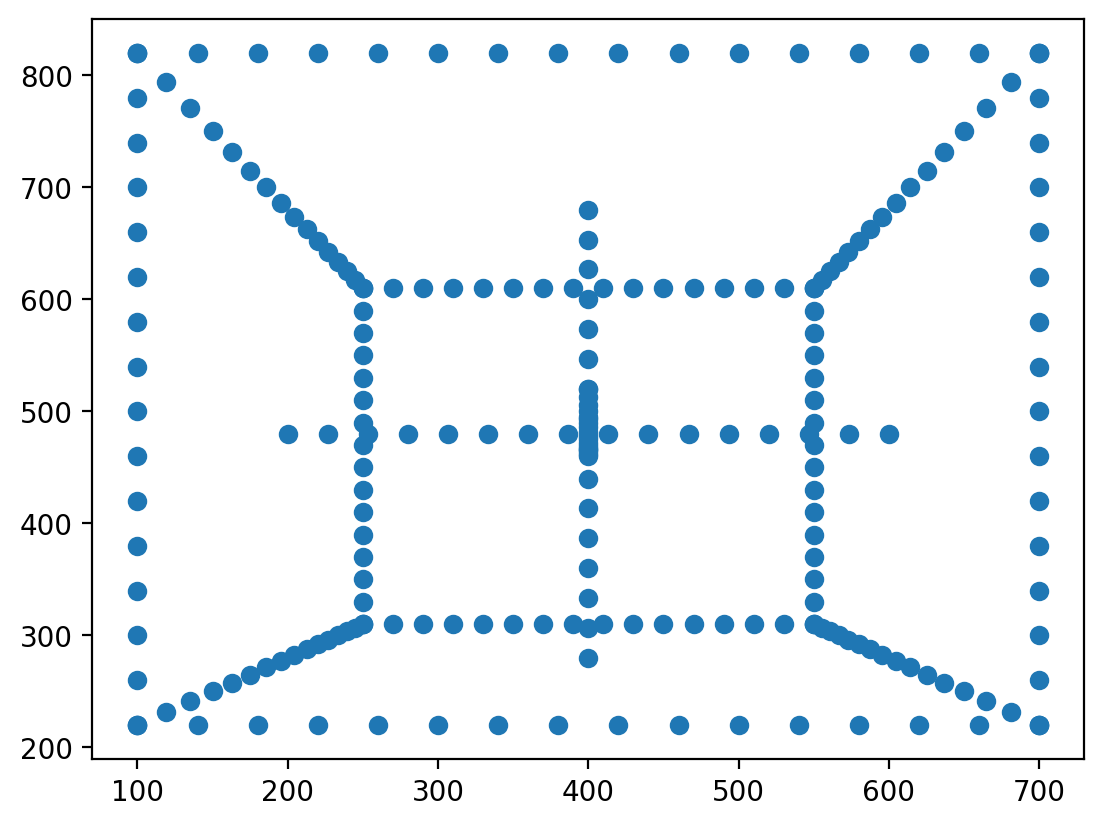

In [4]:
# 2.1
f = 600; alpha = 1; beta = 0; delta_x = 400; delta_y = 400
Q = box3d()
K = np.array([[f, beta*f, delta_x], 
              [0, alpha*f, delta_y], 
              [0, 0, 1]])
R = np.eye(3)
t = np.array([[0, 0.2, 1.5]]).T
q = projectpoints(K, R, t, Q)
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.scatter(q[0,:], q[1,:]);

In [5]:
# all the points are captured by the image sensor
P1 = np.array([[-0.5, -0.5, -0.5]]).T
q = projectpoints(K, R, t, P1)
q
# i.e. it is the lower left corner of the image

array([[100.],
       [220.]])

In [6]:
# 2.2
def dist(xy, coefs):
    delta_r = 0
    for i, k in enumerate(coefs):
        delta_r += k * np.linalg.norm(xy,axis=0) ** (2*(i+1))
    return xy * (1 + delta_r)

def projectpoints_coef(K, R, t, Q, distCoeffs):
    """project 3D points to 2D with distortion
    distCoeffs: array([k3, k5, k7,...])"""
    Rt = np.concatenate((R, t), axis=1)
    return Pi(K @ PiInv(dist(Pi(Rt @ PiInv(Q)), distCoeffs)))

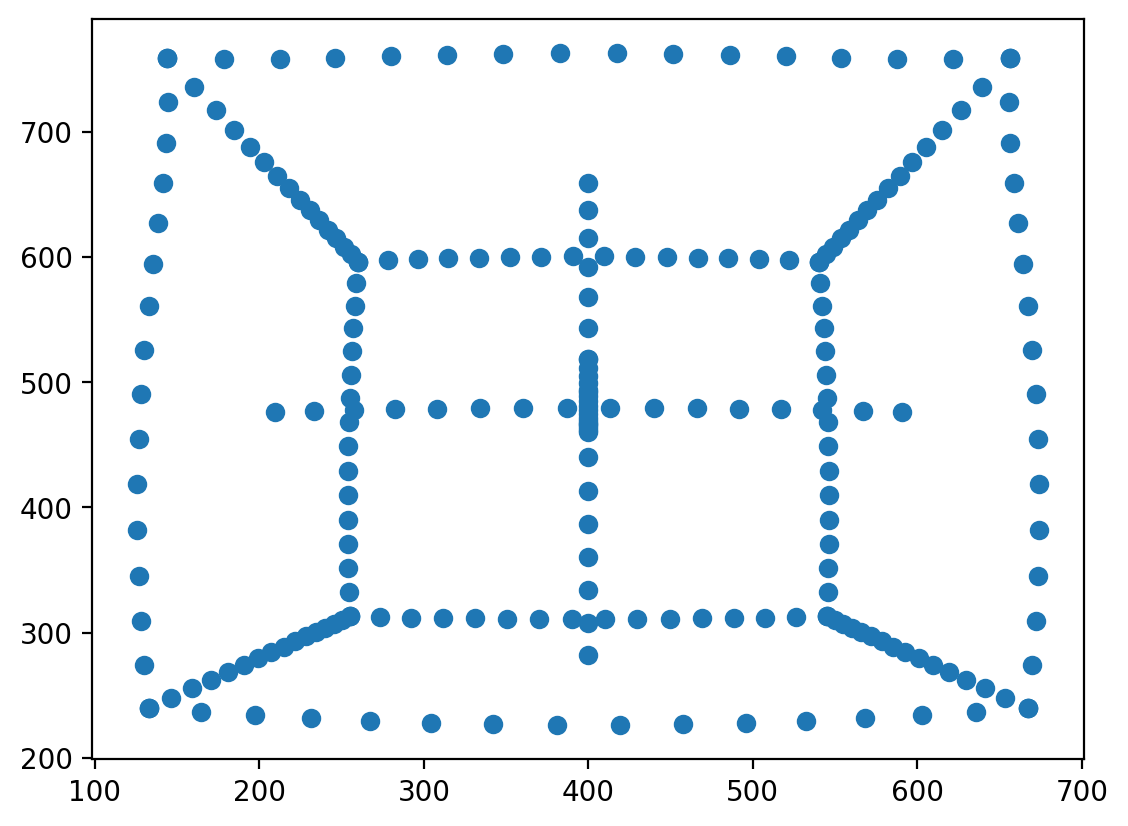

In [7]:
f = 600; alpha = 1; beta = 0; delta_x = 400; delta_y = 400
Q = box3d()
K = np.array([[f, beta*f, delta_x], 
              [0, alpha*f, delta_y], 
              [0, 0, 1]])
R = np.eye(3)
t = np.array([[0, 0.2, 1.5]]).T
q = projectpoints_coef(K, R, t, Q, [-0.4,0.2,0.1])
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.scatter(q[0], q[1]);

In [8]:
P1 = np.array([[-0.5, -0.5, -0.5]]).T
q = projectpoints_coef(K, R, t, P1, [-0.2])
q # should be [120.4, 232.24]

array([[120.4 ],
       [232.24]])

(1080, 1920, 3)

875.00544

array([[875.00544,   0.     , 960.     ],
       [  0.     , 875.00544, 540.     ],
       [  0.     ,   0.     ,   1.     ]])

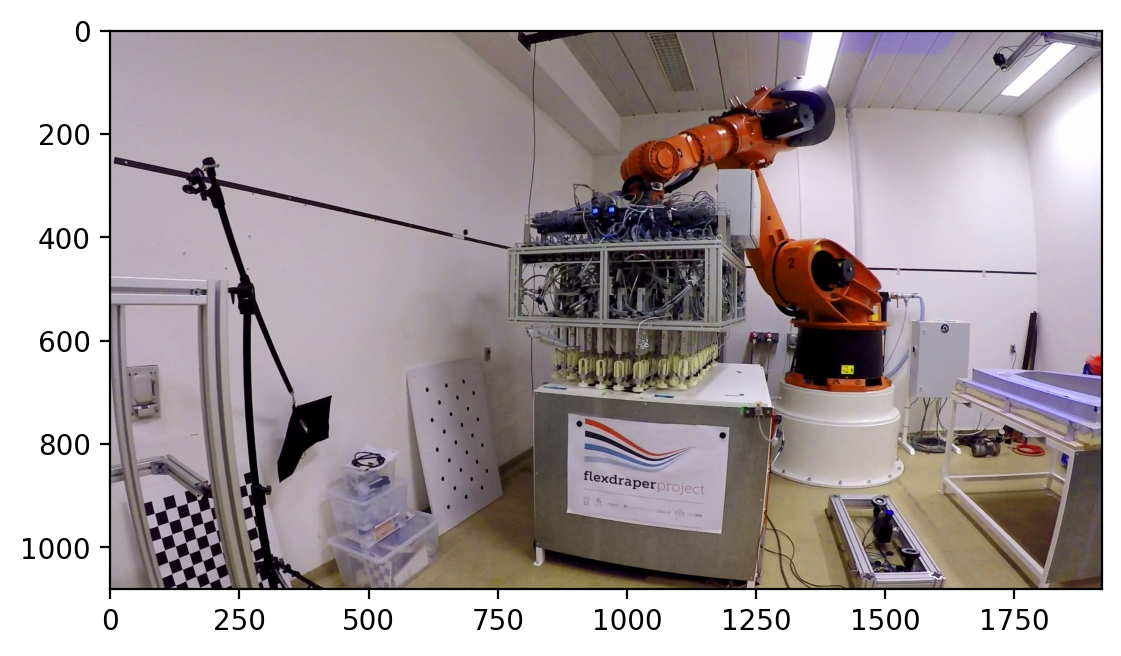

In [9]:
# 2.3
img = cv2.imread("data/gopro_robot.jpg")[:,:,::-1]
img = img.astype(float)/255
plt.figure(dpi=200)
plt.imshow(img)
display(img.shape)
f = 0.455732 * img.shape[1]
display(f)
alpha = 1 
beta = 0
k3 = -0.245031; k5 = 0.071524; k7 = -0.00994978
coefs = [k3, k5, k7]
K = np.array([[f, beta*f, img.shape[1]/2],
              [0, alpha*f, img.shape[0]/2],
              [0, 0, 1]])
K

In [10]:
# 2.4
def undistortImage(im, K, coefs):
    """undistort image with distortion coefficients"""
    x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0])) 
    p = np.stack((x, y, np.ones(x.shape))).reshape(3, -1)
    q = np.linalg.inv(K) @ p
    q_d = PiInv(dist(Pi(q), coefs))
    p_d = K @ q_d
    x_d = p_d[0].reshape(x.shape).astype(np.float32) 
    y_d = p_d[1].reshape(y.shape).astype(np.float32) 
    assert (p_d[2]==1).all(), 'You did a mistake somewhere'
    im_undistorted = cv2.remap(im, x_d, y_d, cv2.INTER_LINEAR)
    return im_undistorted

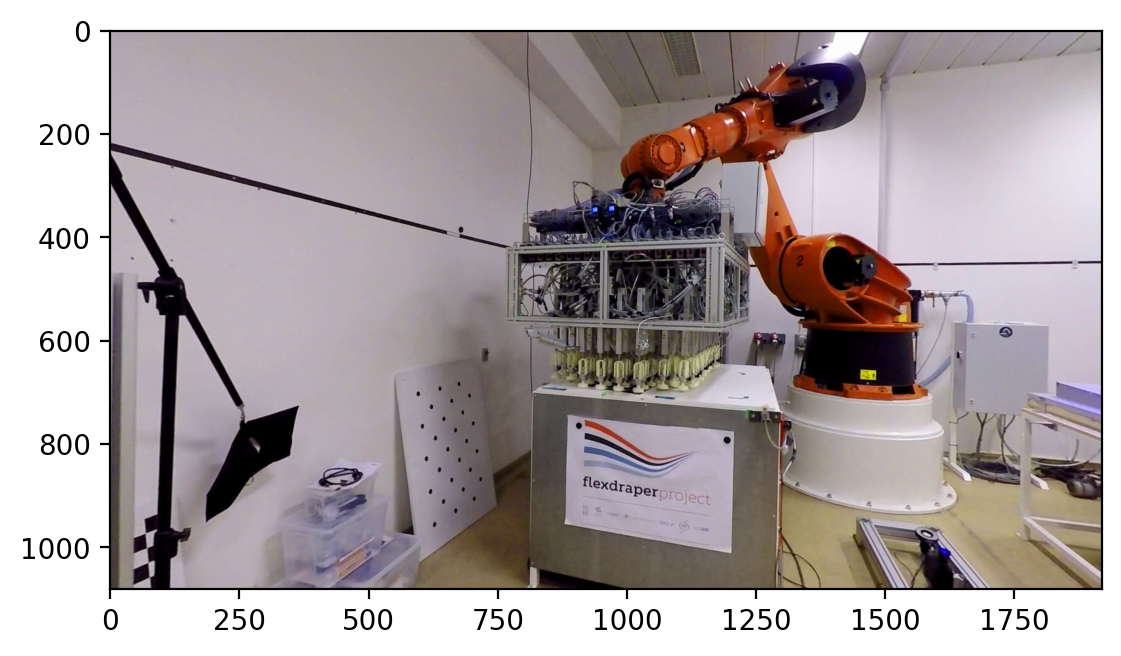

In [11]:
img_undistorted = undistortImage(img, K, coefs)
plt.figure(dpi=200)
plt.imshow(img_undistorted);

In [12]:
# 2.5
p2a = np.array([[1,1]]).T
p2b = np.array([[0,3]]).T
p2c = np.array([[2],[3]])
p2d = np.array([[2,4]]).T

H = np.array([[-2,0,1],
              [1,-2,0],
              [0,0,3]])
q2a = Pi(H @ PiInv(p2a))
q2b = Pi(H @ PiInv(p2b))
q2c = Pi(H @ PiInv(p2c))
q2d = Pi(H @ PiInv(p2d))
display(q2a, q2b, q2c, q2d)

array([[-0.33333333],
       [-0.33333333]])

array([[ 0.33333333],
       [-2.        ]])

array([[-1.        ],
       [-1.33333333]])

array([[-1.],
       [-2.]])

In [25]:
# 2.6
def cross_op(x:np.ndarray):
    x1i = x[0].item()
    y1i = x[1].item()
    return np.array([[0, -1, y1i], [1, 0, -x1i], [-y1i, x1i, 0]])

def hest(q1:np.ndarray, q2:np.ndarray) -> np.ndarray:
    """estimate homography from 2 sets of points
    
    q1: 2xN array of points in image 1
    q2: 2xN array of points in image 2

    returns: 3x3 homography matrix H
    """

    N = q1.shape[0]+1
    K = q1.shape[1]
    B = np.zeros((N*K, N**2))

    for i, (q1i, q2i) in enumerate(zip(q1.T, q2.T)):
        q1i = PiInv(q1i.reshape(-1, 1)); q2i = PiInv(q2i.reshape(-1, 1))
        B[i*N:(i+1)*N] = np.kron(q2i.T, cross_op(q1i))
    U, S, Vh = np.linalg.svd(B)
    V = Vh.T
    H = V[:,-1].reshape(3,3).T
    return H

In [26]:
ps = np.concatenate((p2a, p2b, p2c, p2d), axis=1)
qs = np.concatenate((q2a, q2b, q2c, q2d), axis=1)
H_est = hest(qs, ps)
np.round(H_est)

array([[ 0.,  0., -0.],
       [-0.,  0., -0.],
       [ 0., -0., -1.]])

In [27]:
# tjek at den har frob norm 1, det har den
frob_norm = np.linalg.norm(H_est, "fro"); frob_norm

1.0000000000000002

In [16]:
q2a_est = Pi(H_est @ PiInv(p2a))
display(q2a_est, q2a) # approx the same

array([[-0.33333333],
       [-0.33333333]])

array([[-0.33333333],
       [-0.33333333]])

In [107]:
H = np.array([[-2,0,1],
              [1,-2,0],
              [0,0,3]])

In [108]:
# 2.7
def normalize2d(p:np.ndarray):
    """normalize 2d points, finds the transformation T such that
    
    q_ih = T @ p_ih has mean = [0,0] and std = [1,1] for all q_i
    
    input: 2xN array of points
    """
    mu_x, mu_y = p.mean(axis=1)
    sigma_x, sigma_y = p.std(axis=1)
    T = np.array([[1 / sigma_x, 0, -mu_x / sigma_x],
                  [0, 1 / sigma_y, -mu_y / sigma_y],
                  [0, 0, 1]])
    return T

In [109]:
T = normalize2d(np.concatenate((q2a, q2b, q2c, q2d),axis=1)); T

array([[1.80906807, 0.        , 0.90453403],
       [0.        , 1.46603333, 2.07688055],
       [0.        , 0.        , 1.        ]])

In [110]:
Pi(T @ PiInv(p2a))

array([[2.7136021 ],
       [3.54291389]])

In [116]:
def hest2(q1s:np.ndarray, q2s:np.ndarray, normalise=True) -> np.ndarray:
    """estimate homography from 2 sets of points
    
    q1: 2xN array of points in image 1
    q2: 2xN array of points in image 2

    returns: 3x3 homography matrix H
    """
    N = q1s.shape[0]+1
    K = q1s.shape[1]
    B = np.zeros((N*K, N**2))
    
    if normalise:
        # Get normalization matrices and normalize points)
        T1, T2 = normalize2d(q1s), normalize2d(q2s)
        q1s, q2s = Pi(T1 @ PiInv(q1s)), Pi(T2 @ PiInv(q2s))

    for i, (q1, q2) in enumerate(zip(q1s.T, q2s.T)):
        q1 = PiInv(q1.reshape(-1, 1)); q2 = PiInv(q2.reshape(-1, 1))
        B[i*N:(i+1)*N] = np.kron(q2.T, cross_op(q1))
        
    U, S, Vh = np.linalg.svd(B)
    V = Vh.T
    H_est = V[:,-1].reshape(3,3).T
    # should normalise before doing the svd
    frob_norm = np.linalg.norm(H_est, "fro")
    assert np.allclose(frob_norm, 1), "Something is wrong..."

    # Either normalized or non-normalized homography estimate
    return np.linalg.inv(T1) @ H_est @ T2 if normalise else H_est

In [117]:
H_est = hest2(qs, ps, normalise=True)
display(H_est)
q2a_est = Pi(H_est @ PiInv(p2a))
display(q2a_est, q2a) # should be approx the same

array([[ 3.67070941e-01,  1.37263528e-17, -1.83535471e-01],
       [-1.83535471e-01,  3.67070941e-01,  4.44089210e-16],
       [ 4.35168288e-16, -1.40086446e-16, -5.50606412e-01]])

array([[-0.33333333],
       [-0.33333333]])

array([[-0.33333333],
       [-0.33333333]])

In [118]:
# 2.9 bare test for at se om den virker
q2 = np.random.randn(2, 100) 
q2h = np.vstack((q2, np.ones((1, 100)))) 
H_true = np.random.randn(3,3) 
q1h = H_true @ q2h
q1 = Pi(q1h)

In [153]:
# 2.10
pic1 = cv2.imread("data/p1.jpg")[:,:,::-1]
pic1 = pic1.astype(float)/255
pic2 = cv2.imread("data/p2.jpg")[:,:,::-1]
pic2 = pic2.astype(float)/255
if not os.path.exists("data/p1.pkl"):
    %matplotlib qt
    plt.figure()
    plt.imshow(pic1)
    p1 = plt.ginput(6)
    plt.figure()
    plt.imshow(pic2)
    p2 = plt.ginput(6)
    plt.close('all')

    with open("data/p1.pkl", "wb") as f:
        pickle.dump(p1, f)
    with open("data/p2.pkl", "wb") as f:
        pickle.dump(p2, f)
else:
    with open("data/p1.pkl", "rb") as f:
        p1 = pickle.load(f)
    with open("data/p2.pkl", "rb") as f:
        p2 = pickle.load(f)

In [157]:
%matplotlib inline
p1 = np.array(p1).reshape(-1,2).T
p2 = np.array(p2).reshape(-1,2).T
H_est_img = hest2(p1, p2, normalise=True)
H_est_img

array([[ 4.23964428e-01,  6.23088870e-01, -7.03944155e+02],
       [-1.65184783e-01,  3.91780242e-01,  5.65423596e+02],
       [ 8.16480089e-05,  8.83304468e-05,  2.26674190e-01]])

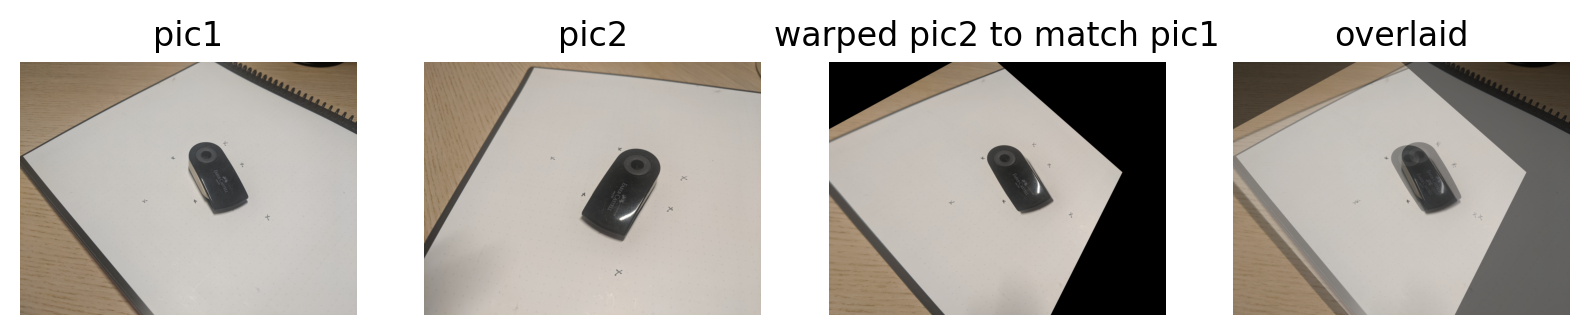

In [158]:
# 2.11
def warpImage(im, H): 
    imWarp = cv2.warpPerspective(im, H, (im.shape[1], im.shape[0]))
    return imWarp
warped_im = warpImage(pic2, H_est_img)
overlaid_im = 0.5*warped_im + 0.5*pic1
fig, ax = plt.subplots(1,4,dpi=200,figsize=(10,5))
ax[0].imshow(pic1)
ax[0].set_title("pic1")
ax[0].set_axis_off()
ax[1].imshow(pic2)
ax[1].set_title("pic2")
ax[1].set_axis_off()
ax[2].imshow(warped_im)
ax[2].set_title("warped pic2 to match pic1")
ax[2].set_axis_off();
ax[3].imshow(overlaid_im)
ax[3].set_title("overlaid")
ax[3].set_axis_off();